In [22]:
# Imports
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [8]:
# Loading data
df = pd.read_csv("labelled_data_final.csv")

# Dropping any rows with missing values
df = df.dropna(subset=["clean_text", "final_label"])

In [9]:
# Applying Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

In [10]:
# Encoding labels
le = LabelEncoder()
labels = le.fit_transform(df["final_label"])

# One-hot encode
categorical_labels = to_categorical(labels)

In [11]:
# Train, test and split data with stratify for balanced classes
X = df["clean_text"]
y = labels 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Tokenizing and Pad train and test data
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_len)


In [13]:
# Encoding train and test data
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [14]:
# Building BiLSTM Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax') 
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Converting one-hot encoded y_train back to original class labels
y_train_labels = y_train 

# Computing class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes = np.unique(y_train_labels),
    y = y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

#### Insight
To address class imbalance, class weights were computed and passed to the model during training. This ensures that the model doesn't overfit to the majority class and learns meaningful representations for all sentiment categories.


In [16]:
# Defining EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:
# Training the model
history = model.fit(
    X_train_pad,
    y_train_encoded,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/10
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 825s 217ms/step - accuracy: 0.8152 - loss: 0.4321 - val_accuracy: 0.8857 - val_loss: 0.2946
Epoch 2/10
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 811s 214ms/step - accuracy: 0.8904 - loss: 0.2628 - val_accuracy: 0.8975 - val_loss: 0.2629
Epoch 3/10
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 795s 209ms/step - accuracy: 0.9008 - loss: 0.2371 - val_accuracy: 0.8961 - val_loss: 0.2585
Epoch 4/10
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 819s 216ms/step - accuracy: 0.9080 - loss: 0.2180 - val_accuracy: 0.9029 - val_loss: 0.2464
Epoch 5/10
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 815s 215ms/step - accuracy: 0.9148 - loss: 0.2033 - val_accuracy: 0.8989 - val_loss: 0.2601
Epoch 6/10
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 794s 209ms/step - accuracy: 0.9207 - loss: 0.1896 - val_accuracy: 0.8979 - val_loss: 0.2678
Epoch 7/10
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 825s 217ms/step - accuracy: 0.9259 - loss: 0.1775 - val_accuracy: 0.9000 - val_loss: 0.2656


In [18]:
# Saving the training history 
with open("bilstm_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [19]:
# Saving the model
model.save("bilstm_model.keras")

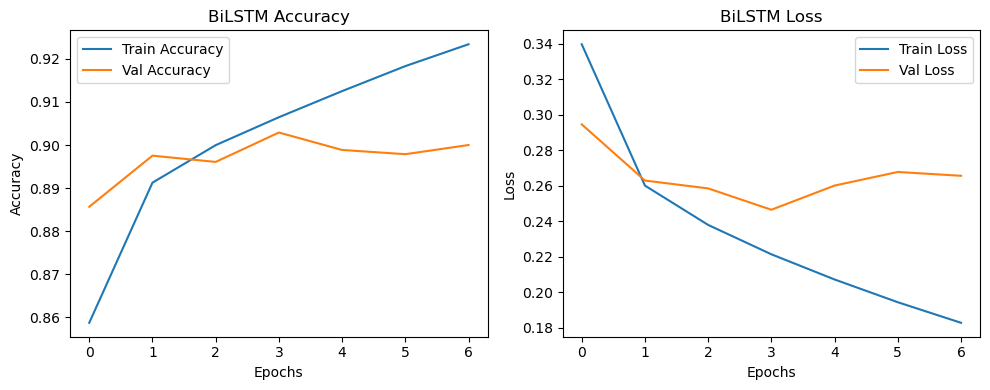

In [20]:
# Plotting Accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('BiLSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BiLSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

9489/9489 ━━━━━━━━━━━━━━━━━━━━ 133s 14ms/step - accuracy: 0.9048 - loss: 0.2437
Test Accuracy: 0.9040
Test Loss: 0.2445


9489/9489 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step
              precision    recall  f1-score   support

    negative       0.94      0.89      0.92    159573
     neutral       0.85      0.93      0.89     59173
    positive       0.88      0.90      0.89     84902

    accuracy                           0.90    303648
   macro avg       0.89      0.91      0.90    303648
weighted avg       0.91      0.90      0.90    303648



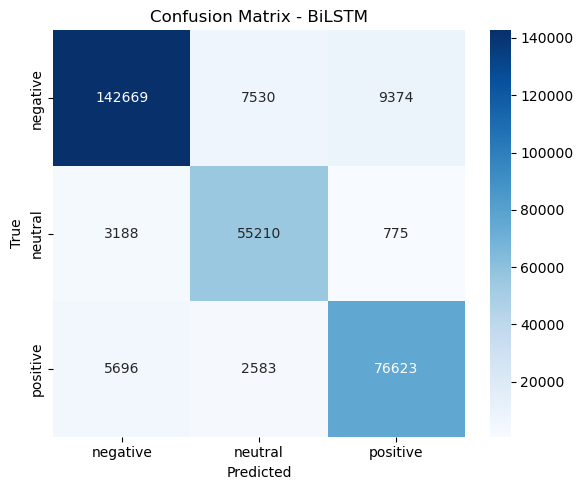

In [23]:
# Generating Classification Report and Confusion Matrix

# Predicting class probabilities
y_pred_probs = model.predict(X_test_pad)

# Converting to label predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test_encoded.argmax(axis=1)

# Generaing report
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plotting Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BiLSTM')
plt.tight_layout()
plt.show()

#### Model Evaluation Summary

The BiLSTM model achieved a test accuracy of 90%, demonstrating strong performance across all sentiment classes. 

- Negative class had the highest precision (94%) and F1-score (92%), which indicates the model is very reliable in detecting dissatisfied customers — aligning well with the goal of early dissatisfaction detection.
- Neutral and positive classes were also classified with solid F1-scores of 89%, showing good balance in prediction.
- The confusion matrix shows that the majority of misclassifications occurred between the neutral and negative classes, which may indicate subtle linguistic ambiguity between dissatisfaction and neutrality in some cases.
- The macro average F1-score of 0.90 reflects consistent performance across all classes, despite the class imbalance in the dataset.
- Overall, the model is well-calibrated, with only a mild performance drop on the validation set compared to the training set, indicating low overfitting.

These results support the feasibility of using BiLSTM models for proactive detection of customer sentiment in real-time support environments.


In [24]:
# Saving results
results_df = pd.DataFrame({
    'Text': X_test,
    'Actual': le.inverse_transform(y_true),
    'Predicted': le.inverse_transform(y_pred)
})

results_df.head(10)

,Text,Actual,Predicted
793463,"no prob, thanks! but on iphone, there is no vi...",negative,negative
364704,nooooooothe temptation is too much!!,negative,neutral
1483474,i have never had a single package delivered on...,negative,negative
866159,hasnt read the emails obviously as this mornin...,negative,negative
270608,mcdonalds pineapple pie is sooooo good its onl...,positive,positive
113253,please improve the signal at jfk especially th...,positive,positive
1389447,because what is this bullshit if the upfront p...,negative,negative
1525957,should i be still waiting for payment of my co...,neutral,neutral
772888,i keep getting playback failure over and over ...,negative,negative
500027,hello \nif you want to get ripped off by a ban...,negative,negative
